In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/american-express-default-prediction/american-express-prediction.ipynb
/kaggle/input/american-express-default-prediction/submission (2).csv


**Problem Statement:**

* Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time.
* How do card issuers know we’ll pay back what we charge? That’s a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.
* Credit default prediction is central to managing risk in a consumer lending business. 
 * Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. 
* Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

* The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. 
 * The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

In [59]:
# Import the Libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd #this finds all the path name
import matplotlib.pyplot as plt
import seaborn as sns # Data Visualization
from datetime import datetime 
import re

In [60]:
#importing SimpleImputer for handling missing value
from sklearn.impute import SimpleImputer

# importing MissingIndicator for handling missing value
from sklearn.impute import MissingIndicator

# importing StandardScaler for standardization
from sklearn.preprocessing import StandardScaler

# importing OnHotEncoder for encoding categorical variable
from sklearn.preprocessing import OneHotEncoder

# importing for transformation
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# importing PCA for handling dimensonality reduction
from sklearn.decomposition import PCA

# importing pipeline for chaining model building activities
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as mp

# importing FeatureUnion for combining transformers
from sklearn.pipeline import FeatureUnion

# importing samplers for handling data imbalance
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 

# importing train_test_split for train and validation split
from sklearn.model_selection import train_test_split

# importing SelectFromModel to select features from model 
from sklearn.feature_selection import SelectFromModel               

In [61]:
# importing classifiers to try with
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# importing metrics required for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# importing RepeatedKFold for cross validation
from sklearn.model_selection import RepeatedKFold
# importing for model evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

# importing RepeatedStratifiedKFold for model evaluation
from sklearn.model_selection import RepeatedStratifiedKFold

# importing GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve

**Dataset:**

* **train_data.csv** - training data with multiple statement dates per customer_ID
* **train_labels.csv** - target label for each customer_ID
* **test_data.csv** - corresponding test data; objective is to predict the target label for each customer_ID
* **sample_submission.csv** - a sample submission file in the correct format

---

In [62]:
# calculate file size in KB, MB, GB
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

# display CSV file with size
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        csvfile=os.path.join(dirname, filename)
        csvfilesize = os.path.getsize(csvfile)
        filesize = convert_bytes(csvfilesize)
        print(f'{csvfile} size is', filesize, 'bytes')

/kaggle/input/amex-default-prediction/sample_submission.csv size is 59.1 MB bytes
/kaggle/input/amex-default-prediction/train_data.csv size is 15.3 GB bytes
/kaggle/input/amex-default-prediction/test_data.csv size is 31.5 GB bytes
/kaggle/input/amex-default-prediction/train_labels.csv size is 29.3 MB bytes
/kaggle/input/american-express-default-prediction/american-express-prediction.ipynb size is 16.2 KB bytes
/kaggle/input/american-express-default-prediction/submission (2).csv size is 93.5 MB bytes


In [63]:
#Loading the training dataset with 100,000 rows
train_data = pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv',nrows = 100000)

# get shape of dataframe
print('Shape of dataset is:', train_data.shape)

# print summary of dataframe
train_data.info()

Shape of dataset is: (100000, 190)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 145.0+ MB


There is a total of 190 variables of which 185 are float 1 variable and 4 are object datatype

In [64]:
# Loading dataset train_labels.csv
train_label_data = pd.read_csv('../input/amex-default-prediction/train_labels.csv')

# get shape of dataframe
print('Shape of dataset is:', train_label_data.shape)

# print summary of dataframe
train_label_data.info()

Shape of dataset is: (458913, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


* There are total 458,913 entries for target label with customer_ID
* There is variable (column) customer_ID which has dtype as object and variable (column) target which has dtype as int64

In [65]:
# Loading dataset test_data.csv
test_data = pd.read_csv('../input/amex-default-prediction/test_data.csv', nrows=100000, index_col='customer_ID')

# get shape of dataframe
print('Shape of dataset is:', test_data.shape)

# print summary of dataframe
# test_df.info(verbose=True)
test_data.info()

Shape of dataset is: (100000, 189)
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to 0246c7eb137ed9b08014d66e29caf1772b0512becef11a1eda0948b8b8908576
Columns: 189 entries, S_2 to D_145
dtypes: float64(185), int64(1), object(3)
memory usage: 145.0+ MB


* There are 185 variables(Columns) as dtype float64, 1 variable(Column) as dtype int64 and 4 variables(Columns) as dtype object, same structure as train_data.csv

In [66]:
# Merge of train_data and train_label_data dataframe using key as customer_ID
train_data = pd.merge(train_data, train_label_data, how="inner", on=["customer_ID"])


# get shape of dataframe
print('Shape of dataset is:', train_data.shape)

# print summary of dataframe
train_data.info()

Shape of dataset is: (100000, 191)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 191 entries, customer_ID to target
dtypes: float64(185), int64(2), object(4)
memory usage: 146.5+ MB


In [67]:
#drop customer_ID and S_2 from train_data dataframe which are not required for model building
train_data.drop(axis=1, columns=['customer_ID','S_2'], inplace=True)

In [68]:
#drop S_2 in test_df dataframe which is not required for model building
test_data.drop(axis=1, columns=['S_2'], inplace=True)

In [69]:
#check if any duplicate row
if (any(train_data.duplicated())):
    print("Yes")
else:
    print("No")

No


In [70]:
#check if any duplicate row in test dataset
if (any(test_data.duplicated())):
    print("Yes")
else:
    print("No")

No


In [71]:
# Check for missing value
if(any(train_data.isna().sum())):
    print("Yes")
else:
    print("No")

Yes


In [72]:
# Check for missing value in test dataset
if(any(test_data.isna().sum())):
    print("Yes")
else:
    print("No")

Yes


In [73]:
#drop variables with missing values >=75% in the train dataframe
i=0
for col in train_data.columns:
    if (train_data[col].isnull().sum()/len(train_data[col])*100) >=75:
        print("Dropping column", col)
        train_data.drop(labels=col,axis=1,inplace=True)
        i=i+1
        
print("Total number of columns dropped in train dataframe", i)

Dropping column D_42
Dropping column D_49
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in train dataframe 23


In [74]:
#drop variables with missing values >=75% in the test dataframe
i=0
for col in test_data.columns:
    if (test_data[col].isnull().sum()/len(test_data[col])*100) >=75:
        print("Dropping column", col)
        test_data.drop(labels=col,axis=1,inplace=True)
        i=i+1
        
print("Total number of columns dropped in test dataframe", i)

Dropping column D_42
Dropping column D_49
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in test dataframe 23


* with the following features being categorical:

**['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']**

In [75]:
#convert dtype for B and D categorical variable to object for training set
train_data = train_data.astype({"B_30": 'str', "B_38": 'str',"D_114": 'str', "D_116": 'str', "D_117": 'str', "D_120": 'str', "D_126": 'str', "D_68": 'str'})
#convert dtype for B and D categorical variable to object for test set
test_data = test_data.astype({"B_30": 'str', "B_38": 'str',"D_114": 'str', "D_116": 'str', "D_117": 'str', "D_120": 'str', "D_126": 'str', "D_68": 'str'})

In [76]:
# separate X and y for further processing
X = train_data.drop(columns='target')
print("Shape of X", X.shape)
y = train_data['target']
print("Shape of y", y.shape)

Shape of X (100000, 165)
Shape of y (100000,)


In [77]:
# define categorical variables (columns)
categorical = list(X.select_dtypes('object').columns)
print(f"Categorical variables (columns) are: {categorical}")

# define numerical variables (columns)
numerical = list(X.select_dtypes('number').columns)
print(f"Numerical variables (columns) are: {numerical}")

Categorical variables (columns) are: ['D_63', 'D_64', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
Numerical variables (columns) are: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_

In [78]:
# define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('scaler', StandardScaler())
])

print(cat_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('scaler', StandardScaler())])


In [79]:
# define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', StandardScaler())
])
print(num_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())])


In [80]:
# combine categorical and numerical pipeline
preprocess = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

print(preprocess)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['D_63', 'D_64', 'D_68', 'B_30', 'B_38',
                                  'D_114', 'D_116', 'D_117', 'D_120',
                                  'D_126']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 

In [81]:
# splitting training data into training and testing (validation) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [82]:
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (75000, 165)
Shape of X_test (25000, 165)
Shape of y_train (75000,)
Shape of y_test (25000,)


---
# MODELLING
___

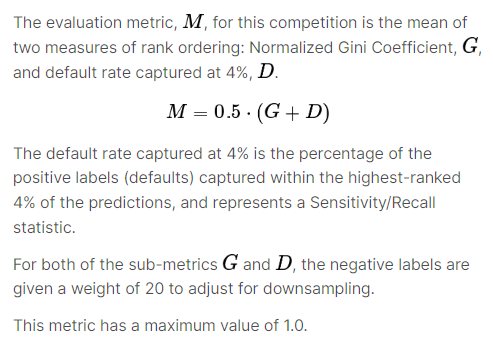

In [83]:
# please refer sample notebook provided under competition page for details
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum() #cumulative sum
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()
    
    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [84]:
# function for display of model training and validation score
def model_score(model_name):
    print("#######################################################################")
    print("Training and Evaluation using", model_name)
    print("#######################################################################")
    print("preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling")
    print("preprocess - Numerical: Missing value Impute and Scaling")
    print("###########################################################################")
    model = pipe.fit(X_train, y_train)  
    print("#######################################################################")
    print (model)
    print("#######################################################################")
    print("model training score: %.3f" % pipe.score(X_train, y_train))
    print("model validation score: %.3f" % pipe.score(X_test, y_test))
    print("#######################################################################")
    print("Amex Evaluation Metric - Training: %.3f"% amex_metric(pd.DataFrame(y_train), pd.DataFrame(pipe.predict(X_train), columns=['prediction'])))
    print("Amex Evaluation Metric - Validation: %.3f"% amex_metric(pd.DataFrame(y_test), pd.DataFrame(pipe.predict(X_test), columns=['prediction'])))
    print("#######################################################################")

In [85]:
# function for display of cross validation score
def model_cross_validation_score(model_name):
    print("#######################################################################")
    print("Training and Evaluation with Cross Validation using",model_name)
    print("#######################################################################")
    # using scoring with classification metrics
    scoring = ['accuracy', 'precision', 'recall','f1','roc_auc']
    #using RepeatedStratifiedKFold as cross validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
    # cross validation returning both train and test score
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=True,return_estimator=True)
    print('Training Score: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f},f1-score: {:.2f}, ROC AUC: {:.2f}'.format(np.mean(scores['train_accuracy']),np.mean(scores['train_precision']), np.mean(scores['train_recall']), np.mean(scores['train_f1']), np.mean(scores['train_roc_auc'])))
    print('Validation Score: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f},f1-score: {:.2f}, ROC AUC: {:.2f}'.format(np.mean(scores['test_accuracy']),np.mean(scores['test_precision']), np.mean(scores['test_recall']), np.mean(scores['test_f1']), np.mean(scores['test_roc_auc'])))
    print("#######################################################################")

In [86]:
# function for display of model score via RandomizedSearchCV
def model_random_search_score(model_name):
    print("#######################################################################")
    print("Training and Evaluation with RandomizedSearchCV using",model_name)
    print("#######################################################################")
    random_search.fit(X_train,y_train)
    model = random_search.best_estimator_
    score = random_search.best_score_
    print ("Best Estimator for", model_name,"is", model,"with best score as",score)
    print("#######################################################################")
    print("Amex Evaluation Metric - Training: %.3f"% amex_metric(pd.DataFrame(y_train), pd.DataFrame(model.predict(X_train), columns=['prediction'])))
    print("Amex Evaluation Metric - Validation: %.3f"% amex_metric(pd.DataFrame(y_test), pd.DataFrame(model.predict(X_test), columns=['prediction'])))
    print("#######################################################################")

___
Using Markdown for Model building
___

In [87]:
# pipeline steps required for model building,training and evaluation
steps = [
        ('preprocess', preprocess),
        ('over_sampler',SMOTE(random_state = 42)),
        ('under_sampler',RandomUnderSampler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 10, random_state = 42, n_jobs = -1))),
        ('dimension_reduction', PCA(n_components='mle',random_state = 42)),
        ('model_estimator', RandomForestClassifier(random_state = 42))
    ]
pipe = Pipeline(steps, verbose=True)

In [88]:
# using custom function to display model training and validation score
model_score("RandomForestClassifier")

#######################################################################
Training and Evaluation using RandomForestClassifier
#######################################################################
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
###########################################################################
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.5s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   9.0s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.7s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.2s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.0min
#######################################################################
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
        

* Using XGBClassifier

In [89]:
# using XGBClassifier
pipe.set_params(model_estimator=XGBClassifier())
# using custom function to display model training and validation score
model_score("XGBClassifier")

#######################################################################
Training and Evaluation using XGBClassifier
#######################################################################
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
###########################################################################
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.8s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.7s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.3s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.7s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processi

In [90]:
#using custom function to display cross validation score
model_cross_validation_score("XGBClassifier")

#######################################################################
Training and Evaluation with Cross Validation using XGBClassifier
#######################################################################
Training Score: Accuracy: 0.94, Precision: 0.83, Recall: 0.97,f1-score: 0.89, ROC AUC: 0.99
Validation Score: Accuracy: 0.89, Precision: 0.73, Recall: 0.90,f1-score: 0.81, ROC AUC: 0.96
#######################################################################


In [91]:
# using LGBMClassifier
pipe.set_params(model_estimator=LGBMClassifier())
# using custom function to display model training and validation score
model_score("LGBMClassifier")

#######################################################################
Training and Evaluation using LGBMClassifier
#######################################################################
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
###########################################################################
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   9.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.5s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.2s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total=   4.5s
#######################################################################
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                

___
Using LGBMClassifier with Cross-Validation and scoring with accuracy, precision, recall, f1-score and ROC AUC
___

In [92]:
#using custom function to display cross validation score
model_cross_validation_score("LGBMClassifier")

#######################################################################
Training and Evaluation with Cross Validation using LGBMClassifier
#######################################################################
Training Score: Accuracy: 0.88, Precision: 0.70, Recall: 0.93,f1-score: 0.80, ROC AUC: 0.96
Validation Score: Accuracy: 0.87, Precision: 0.67, Recall: 0.91,f1-score: 0.77, ROC AUC: 0.95
#######################################################################


In [93]:
# using CatBoostClassifier
pipe.set_params(model_estimator=CatBoostClassifier(iterations=3,learning_rate=1,depth=6))
# using custom function to display model training and validation score
model_score("CatBoostClassifier")

#######################################################################
Training and Evaluation using CatBoostClassifier
#######################################################################
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
###########################################################################
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.9s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  10.0s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.3s
0:	learn: 0.3732592	total: 36.6ms	remaining: 73.2ms
1:	learn: 0.3584420	total: 66.2ms	remaining: 33.1ms
2:	learn: 0.3476547	total: 94.5ms	remaining: 0us
[Pipeline] ... (step 6 of 6) Processing model_estimator, total=   0.4s
###################

---
Using CatBoostClassifier with Cross-Validation and scoring with accuracy, precision, recall, f1-score and ROC AUC

---

In [94]:
#using custom function to display cross validation score
model_cross_validation_score("CatBoostClassifier")

#######################################################################
Training and Evaluation with Cross Validation using CatBoostClassifier
#######################################################################
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.1s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  31.3s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.8s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 3.7min
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.4s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  30.7s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.7s
[P

* Using RandomizedSearchCV for XGBClassifier

In [95]:
# using parameters for RandomizedSearchCV for XGBClassifier
param_random = dict(model_estimator=[XGBClassifier()],model_estimator__learning_rate= [0.05,0.10,0.15,0.20,0.25,0.30],model_estimator__max_depth= [ 3, 4, 5, 6, 8, 10, 12, 15],model_estimator__min_child_weight=[ 1, 3, 5, 7 ], model_estimator__gamma=[ 0.0, 0.1, 0.2 , 0.3, 0.4 ], model_estimator__colsample_bytree =[ 0.3, 0.4, 0.5 , 0.7 ])
random_search = RandomizedSearchCV(pipe, param_distributions=param_random, n_iter=1, cv=3, scoring='roc_auc', verbose=3,random_state=42)

In [96]:
#using custom function to display best estimator and score
model_random_search_score("XGBClassifier")

#######################################################################
Training and Evaluation with RandomizedSearchCV using XGBClassifier
#######################################################################
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   1.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   4.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   6.5s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.2s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total=  16.6s
[CV 1/3] END model_estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gp

In [97]:
# using parameters for RandomizedSearchCV for LGBMClassifier
param_random = dict(model_estimator=[LGBMClassifier()],model_estimator__num_leaves= [20,40,60,80,100],model_estimator__min_child_samples= [5,10,15],model_estimator__max_depth=[-1,5,10,20], model_estimator__learning_rate=[0.05,0.1,0.2], model_estimator__reg_alpha =[0,0.01,0.03])
random_search = RandomizedSearchCV(pipe, param_distributions=param_random, n_iter=1, cv=3, scoring='roc_auc', verbose=3,random_state=42)

In [98]:
#using custom function to display best estimator and score
model_random_search_score("LGBMClassifier")

#######################################################################
Training and Evaluation with RandomizedSearchCV using LGBMClassifier
#######################################################################
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   1.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   4.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   6.5s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.2s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total=   5.5s
[CV 1/3] END model_estimator=LGBMClassifier(), model_estimator__learning_rate=0.05, model_estimator__max_depth=10, model_estimator__min_child_samples=5, model_estimator__num_leaves=100, model_estimator__reg_alpha=0;, score=0.946 total time=  18.7s
[Pipeline] ........ (step 1 of 6) Processing preproce

---
**Prediction/Sample Submission file**

---

In [99]:
test_data_new=test_data.reset_index()

In [100]:
del test_data

In [102]:
X_test_predict = test_data_new.groupby('customer_ID').tail(1)

In [105]:
model = random_search.best_estimator_

In [106]:
# prediction on test dataset
y_test_pred = model.predict(X_test_predict)

In [107]:
# generate submission file
output = pd.DataFrame({'customer_ID': X_test_predict.index,'prediction': y_test_pred})
output.to_csv('submission.csv', index=False, header=True)

In [108]:
output.head(1000)

,customer_ID,prediction
0,8,0
1,21,0
2,34,0
3,47,1
4,60,1
...,...,...
995,12304,0
996,12317,0
997,12322,0
998,12335,0
